# Import Libraries

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

2.17.1


# Import Data

In [ ]:
# Read the headers
with open('/content/CommercialTransactionOffice20240913093331.csv', 'r') as f:
    headers = f.readline().strip().split(',')

# Read the data ignoring row 1 headers

data = pd.read_csv('/content/CommercialTransactionOffice20240913093331.csv', header=None, skiprows=1)
data2 = pd.read_csv('/content/CommercialTransactionRetail20240913093404.csv', header=None, skiprows=1)
data3 = pd.read_csv('/content/CommercialTransactionShop20240913093311.csv', header=None, skiprows=1)

# Combine data
data = pd.concat([data, data2, data3], axis=0)
data.columns = headers

print(headers)
print(data.head())

# count number of rows of data
print("Rows of imported data: " , len(data))

['Project Name', 'Street Name', 'Property Type', 'Transacted Price ($)', 'Area (SQFT)', 'Unit Price ($ PSF)', 'Sale Date', 'Type of Area', 'Area (SQM)', 'Unit Price ($ PSM)', 'Tenure', 'Postal District', 'Floor Level']
                Project Name       Street Name Property Type  \
0              TONG BUILDING      ORCHARD ROAD        Office   
1  ORIENTAL VENTURE BUILDING      GEYLANG ROAD        Office   
2               WOODS SQUARE  WOODLANDS SQUARE        Office   
3               WOODS SQUARE  WOODLANDS SQUARE        Office   
4                  HAVELOCK2     HAVELOCK ROAD        Office   

  Transacted Price ($) Area (SQFT) Unit Price ($ PSF) Sale Date Type of Area  \
0           31,330,000    6,867.43              4,562    Sep-24       Strata   
1            1,480,000    1,097.93              1,348    Aug-24       Strata   
2            1,975,490      947.23              2,086    Aug-24       Strata   
3            1,163,581      559.73              2,079    Aug-24       Strata

# Clean Data

In [ ]:
# Delete Empty rows
data.dropna(how='all', inplace=True)

# convert string to float
data['Transacted Price ($)'] = data['Transacted Price ($)'].str.replace(',', '')
data['Transacted Price ($)'] = data['Transacted Price ($)'].astype(float)

data['Area (SQFT)'] = data['Area (SQFT)'].str.replace(',', '')
data['Area (SQFT)'] = data['Area (SQFT)'].astype(float)

data['Unit Price ($ PSF)'] = data['Unit Price ($ PSF)'].str.replace(',', '')
data['Unit Price ($ PSF)'] = data['Unit Price ($ PSF)'].astype(float)

data['Area (SQM)'] = data['Area (SQM)'].str.replace(',', '')
data['Area (SQM)'] = data['Area (SQM)'].astype(float)

data['Unit Price ($ PSM)'] = data['Unit Price ($ PSM)'].str.replace(',', '')
data['Unit Price ($ PSM)'] = data['Unit Price ($ PSM)'].astype(float)

# Print datatype
print(data.dtypes)

Project Name             object
Street Name              object
Property Type            object
Transacted Price ($)    float64
Area (SQFT)             float64
Unit Price ($ PSF)      float64
Sale Date                object
Type of Area             object
Area (SQM)              float64
Unit Price ($ PSM)      float64
Tenure                   object
Postal District           int64
Floor Level              object
dtype: object


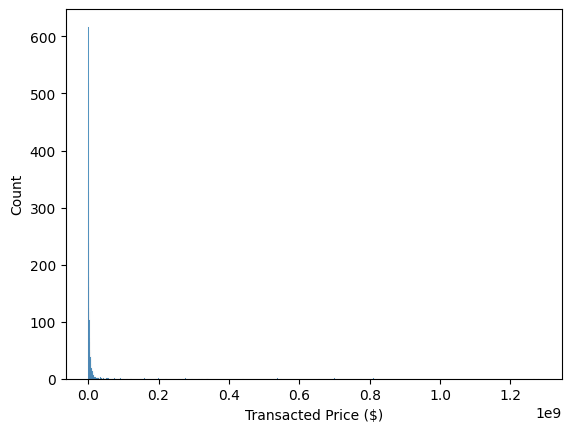

In [ ]:
# print distribution of transacteed price
sns.histplot(data['Transacted Price ($)'])
plt.show()

# Prepare Data and Split into Train and Test



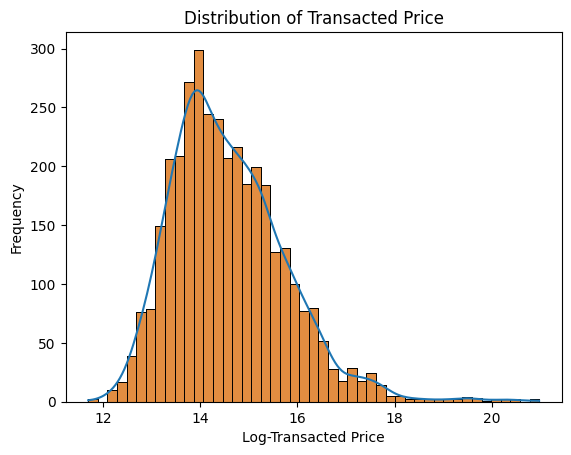

In [ ]:
# prompt: Create linear regression model for predicting transacted price without the unit price columns and for categorical data, use one hot encoding

# Select relevant features
features = ['Area (SQFT)', 'Area (SQM)', 'Property Type', 'Street Name', 'Tenure', 'Type of Area', 'Postal District', "Floor Level"]
X = data[features].copy()  # Use .copy() to avoid SettingWithCopyWarning
y = data['Transacted Price ($)'].copy()

# test some modification !!!
# Example of log transforming Area and Price
X['Area (SQM)'] = np.log1p(X['Area (SQM)'])
X['Area (SQFT)'] = np.log1p(X['Area (SQFT)'])
y = np.log1p(y)  # if your target (price) is also skewed

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# One-Hot Encoding Example (for small number of categories)
X_encoded = pd.get_dummies(X, columns=['Property Type', 'Street Name', 'Tenure', 'Type of Area', 'Postal District', "Floor Level"])

from sklearn.model_selection import train_test_split

# Assuming 'y' is your target variable (e.g., price)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# export my X_encoded headers to .dat
headers = X_encoded.columns
np.savetxt('headers.dat', headers, fmt='%s')

# print distribution of transacteed price
sns.histplot(y, kde=True)
plt.title("Distribution of Transacted Price")
plt.xlabel("Log-Transacted Price")
plt.ylabel("Frequency")
sns.histplot(y)
plt.show()

# Define XGBoost Model

Mean Squared Error: 0.1130328679665426
R-squared: 0.9253705094811318


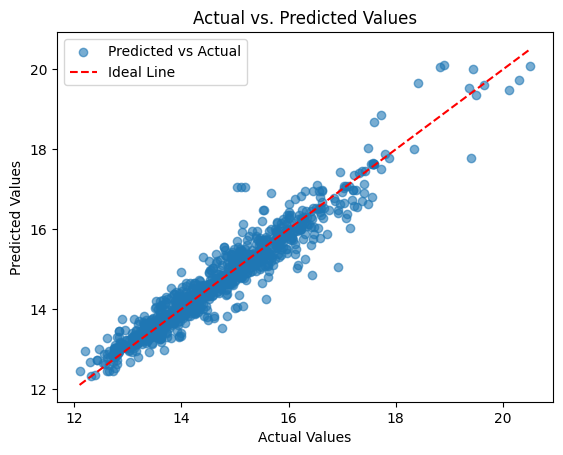

In [ ]:
import xgboost as xgb

# Convert data to DMatrix (optional but recommended for efficiency)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Use appropriate objective for regression
    max_depth=6,  # Depth of each tree
    learning_rate=0.2,  # Step size shrinkage
    n_estimators=100  # Number of boosting rounds
)

# Train the model
model.fit(X_train, y_train)


from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

import matplotlib.pyplot as plt

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred, alpha=0.6, label="Predicted vs Actual")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

# Add a 45-degree line (perfect prediction line)
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Ideal Line")

plt.legend()
plt.show()

Analyse Result

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:49:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error: 0.11359494448756417
R-squared: 0.924999400748326
RMSE: 0.33703849110682327
count    3569.000000
mean       14.583518
std         1.175627
min        11.695255
25%        13.751506
50%        14.419827
75%        15.271798
max        20.971288
Name: Transacted Price ($), dtype: float64


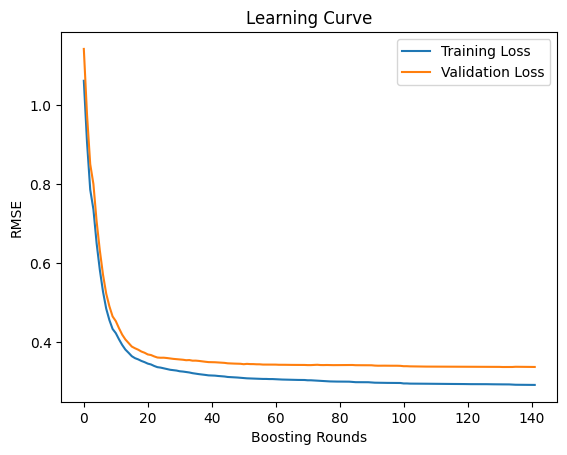

In [ ]:
# Define the XGBoost model parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,               # Test 4, 6, 8
    'learning_rate': 0.2,         # Lower learning rate
    'n_estimators': 100,          # Increase number of trees
    'gamma': 0.1,                 # Minimum loss reduction
    'min_child_weight': 2,        # Prevent overfitting
    'subsample': 0.7,             # Use 80% of the data for training
    'colsample_bytree': 0.7,      # Use 80% of features per tree
    'lambda': 3.5,                # L2 regularization
    'alpha': 2.5,                 # L1 regularization
    'eval_metric': 'rmse'         # Keep RMSE for monitoring
}


# Train the model using xgb.train, store the results
evals_result = {}  # Initialize an empty dictionary to store results
model = xgb.train(
    params,
    dtrain,
    num_boost_round=189,  # Use num_boost_round instead of n_estimators
    evals=[(dtrain, 'train'), (dtest, 'eval')],  # Move eval_set here
    early_stopping_rounds=10,  # Move early_stopping_rounds here
    verbose_eval=False,  # Use verbose_eval instead of verbose
    evals_result=evals_result  # Store evaluation results in the dictionary
)

# Get predictions using the trained model
y_pred = model.predict(dtest)

# Access the evaluation results from the dictionary
train_loss = evals_result['train']['rmse']
val_loss = evals_result['eval']['rmse']

#evaluate
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
#print rmse & mse, rsquerd
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'RMSE: {np.sqrt(mse)}')

import pandas as pd
# Assuming your target is in a pandas DataFrame or Series
summary = y.describe()
print(summary)


# Plot
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Learning Curve')
plt.legend()
plt.show()

# #Residual Plot
# residuals = y_test - y_pred
# plt.scatter(y_pred, residuals)
# plt.axhline(0, color='red', linestyle='--')
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.title('Residual Plot')
# plt.show()

# #Distribution of Errors (Histogram)
# plt.hist(residuals, bins=30, edgecolor='black')
# plt.xlabel('Residuals')
# plt.ylabel('Frequency')
# plt.title('Distribution of Residuals')
# plt.show()

# #plot actual vs predicted
# plt.scatter(y_test, y_pred)
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Actual vs. Predicted Values')
# plt.show()

Mean Squared Error: 0.11359494448756417
R-squared: 0.924999400748326


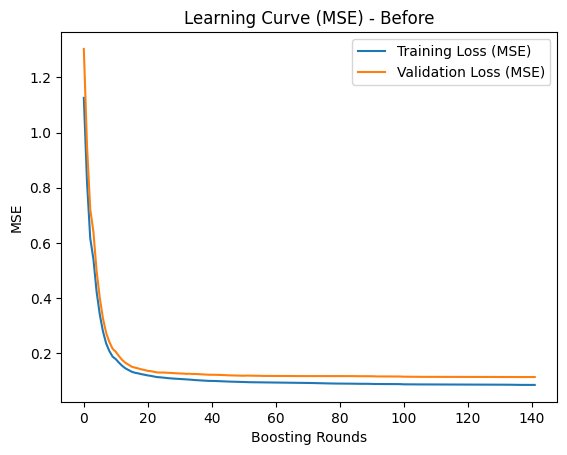

In [ ]:
# MSE To plot learning curve instead
# Define the XGBoost model parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,               # Test 4, 6, 8
    'learning_rate': 0.2,         # Lower learning rate
    'gamma': 0.1,                 # Minimum loss reduction
    'min_child_weight': 2,        # Prevent overfitting
    'subsample': 0.7,             # Use 80% of the data for training
    'colsample_bytree': 0.7,      # Use 80% of features per tree
    'lambda': 3.5,                # L2 regularization
    'alpha': 2.5,                 # L1 regularization
    'eval_metric': 'rmse'         # Use RMSE for evaluation
}

# Train the model using xgb.train, store the results
evals_result = {}  # Initialize an empty dictionary to store results
model = xgb.train(
    params,
    dtrain,
    num_boost_round=189,  # Use num_boost_round instead of n_estimators
    evals=[(dtrain, 'train'), (dtest, 'eval')],  # Move eval_set here
    early_stopping_rounds=10,  # Move early_stopping_rounds here
    verbose_eval=False,  # Use verbose_eval instead of verbose
    evals_result=evals_result  # Store evaluation results in the dictionary
)

# Get predictions using the trained model
y_pred = model.predict(dtest)

# Access the evaluation results from the dictionary and square RMSE to get MSE
train_loss_rmse = evals_result['train']['rmse']
val_loss_rmse = evals_result['eval']['rmse']

# Convert RMSE to MSE for plotting
train_loss_mse = [x**2 for x in train_loss_rmse]
val_loss_mse = [x**2 for x in val_loss_rmse]

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score

# Calculate MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print MSE and R-squared
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot MSE Learning Curve
plt.plot(train_loss_mse, label='Training Loss (MSE)')
plt.plot(val_loss_mse, label='Validation Loss (MSE)')
plt.xlabel('Boosting Rounds')
plt.ylabel('MSE')
plt.title('Learning Curve (MSE) - Before')
plt.legend()
plt.show()

# Save the model
model.save_model('0001.model.ubj')

     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0           0.987328        0.012726        0.989210       0.053089
1           0.856143        0.010590        0.860777       0.048796
2           0.755343        0.009984        0.761878       0.043814
3           0.677524        0.008048        0.685727       0.042121
4           0.618773        0.007443        0.630368       0.039253
..               ...             ...             ...            ...
195         0.337515        0.001858        0.373452       0.012514
196         0.337494        0.001896        0.373444       0.012504
197         0.337494        0.001896        0.373458       0.012484
198         0.337465        0.001890        0.373526       0.012472
199         0.337419        0.001887        0.373525       0.012426

[200 rows x 4 columns]


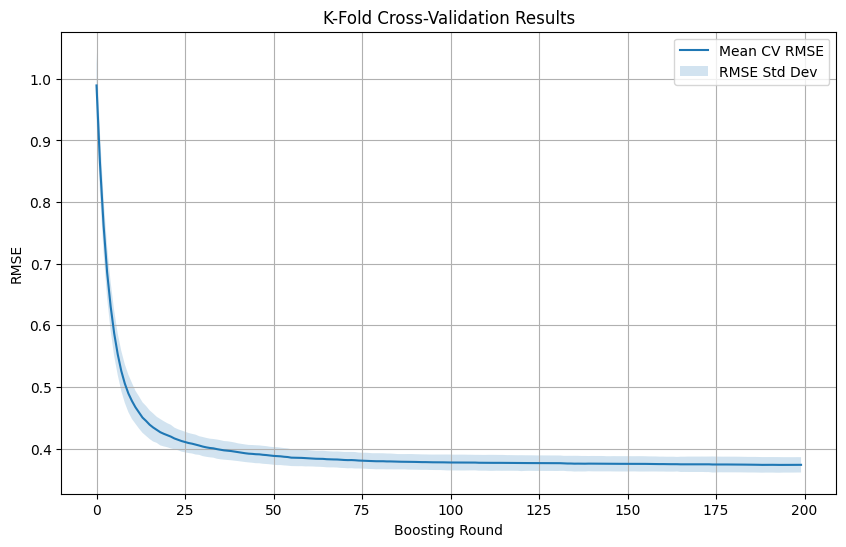

In [ ]:
from sklearn.model_selection import KFold
# Define the XGBoost model parameters (same as before)
params = {
    'objective': 'reg:squarederror',
    'max_depth': 4,
    'learning_rate': 0.2,
    'gamma': 0.1,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 5,
    'alpha': 4,
    'eval_metric': 'rmse'
}

# Define the number of folds (e.g., 5-fold cross-validation)
num_folds = 5

# Perform k-fold cross-validation
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=200,
    nfold=num_folds,
    metrics='rmse',  # Specify the metric
    as_pandas=True,  # Return results as a Pandas DataFrame
    seed=42, #for reproducibility
    early_stopping_rounds=10 #if a metric isn't improving for 10 rounds, stop
)

# Print the cross-validation results
print(cv_results)

# Access the mean and standard deviation of the RMSE for each boosting round
mean_rmse = cv_results['test-rmse-mean']
std_rmse = cv_results['test-rmse-std']

#To plot the CV results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(mean_rmse, label='Mean CV RMSE')
plt.fill_between(range(len(mean_rmse)), mean_rmse - std_rmse, mean_rmse + std_rmse, alpha=0.2, label='RMSE Std Dev')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('K-Fold Cross-Validation Results')
plt.legend()
plt.grid(True)
plt.show()

# # Train the final model on the entire training set using the best num_boost_round
# best_n_estimators = len(mean_rmse)
# model = xgb.train(params, dtrain, num_boost_round=best_n_estimators, evals=[(dtrain, 'train')])

# y_pred = model.predict(dtest)


In [ ]:
# test_data = ['CONCORDE SHOPPING CENTRE','OUTRAM ROAD','Office','688000', '376.74', '1.826', 'Dec-24','Strata', '35.0', '19657', '99 yrs lease commencing from 1980', '03', '01 to 05']
test_data = ['THOMSON V TWO','SIN MING ROAD','Retail','300000.0', '53.82','5.574', 'Jul-21','Strata','5.0', '60000.0', 'Freehold', '20', '01 to 05']
# test_data = ['REGENCY SUITES','KIM TIAN ROAD','Office','2120000','1033.34','2.052','Nov-24','Strata','96','22083','Freehold','03','06 to 10']

# Select relevant features
features = ['Area (SQFT)', 'Area (SQM)', 'Property Type', 'Street Name', 'Tenure', 'Type of Area', 'Postal District', "Floor Level"]
headers = ['Project Name', 'Street Name', 'Property Type', 'Transacted Price ($)', 'Area (SQFT)', 'Unit Price ($ PSF)', 'Sale Date', 'Type of Area', 'Area (SQM)', 'Unit Price ($ PSM)', 'Tenure', 'Postal District', 'Floor Level']

# insert data into df with headers
test_data = pd.DataFrame([test_data], columns=headers)

# Consolidate cleaning steps for columns with potential commas
for col in ['Transacted Price ($)', 'Area (SQFT)', 'Unit Price ($ PSF)', 'Area (SQM)', 'Unit Price ($ PSM)']:
    test_data[col] = test_data[col].str.replace(',', '').astype(float)


# Print datatype
print(test_data.dtypes)

# set x and y
X_test_data = test_data[features]
y_test_data = test_data['Transacted Price ($)']

# transform data
X_test_data.loc[:, 'Area (SQM)'] = np.log1p(X_test_data['Area (SQM)'])
X_test_data.loc[:, 'Area (SQFT)'] = np.log1p(X_test_data['Area (SQFT)'])

# One-Hot Encoding Example (for small number of categories)
X_test_data_encoded = pd.get_dummies(X_test_data, columns=['Property Type', 'Street Name', 'Tenure', 'Type of Area', 'Postal District', "Floor Level"])

#read One-hot encoded headers
with open('/content/headers.dat', 'r') as f:
    test_headers = f.read().splitlines()

# Align columns of X_test_data_encoded with One-hot encoded headers
X_test_data_encoded = X_test_data_encoded.reindex(columns = test_headers, fill_value=0)

# Load Model
model = xgb.Booster()
model.load_model('0001.model.ubj')
test_data_dmatrix = xgb.DMatrix(X_test_data_encoded)
predicted_price = model.predict(test_data_dmatrix)

# revert np.log1p
predicted_price = np.expm1(predicted_price)
print("Predicted: ", predicted_price[0])
print("Actual: ", y_test_data[0])

Project Name             object
Street Name              object
Property Type            object
Transacted Price ($)    float64
Area (SQFT)             float64
Unit Price ($ PSF)      float64
Sale Date                object
Type of Area             object
Area (SQM)              float64
Unit Price ($ PSM)      float64
Tenure                   object
Postal District          object
Floor Level              object
dtype: object
Predicted:  299045.28
Actual:  300000.0


In [ ]:
# Load the model
model = xgb.Booster()
model.load_model('0001.model.ubj')

# Predict on test data
y_pred = model.predict(test_data_dmatrix)

# revert y_pred
y_pred = np.expm1(y_pred)

#print original and pred
print("Predicted: ", y_pred[0])
print("Actual: ", y_test_data[0])
#print percentage diff
print("Percentage difference: ", (y_pred[0] - y_test_data[0]) / y_test_data[0] * 100)

Predicted:  299045.28
Actual:  300000.0
Percentage difference:  -0.31823958333333335


<Axes: >

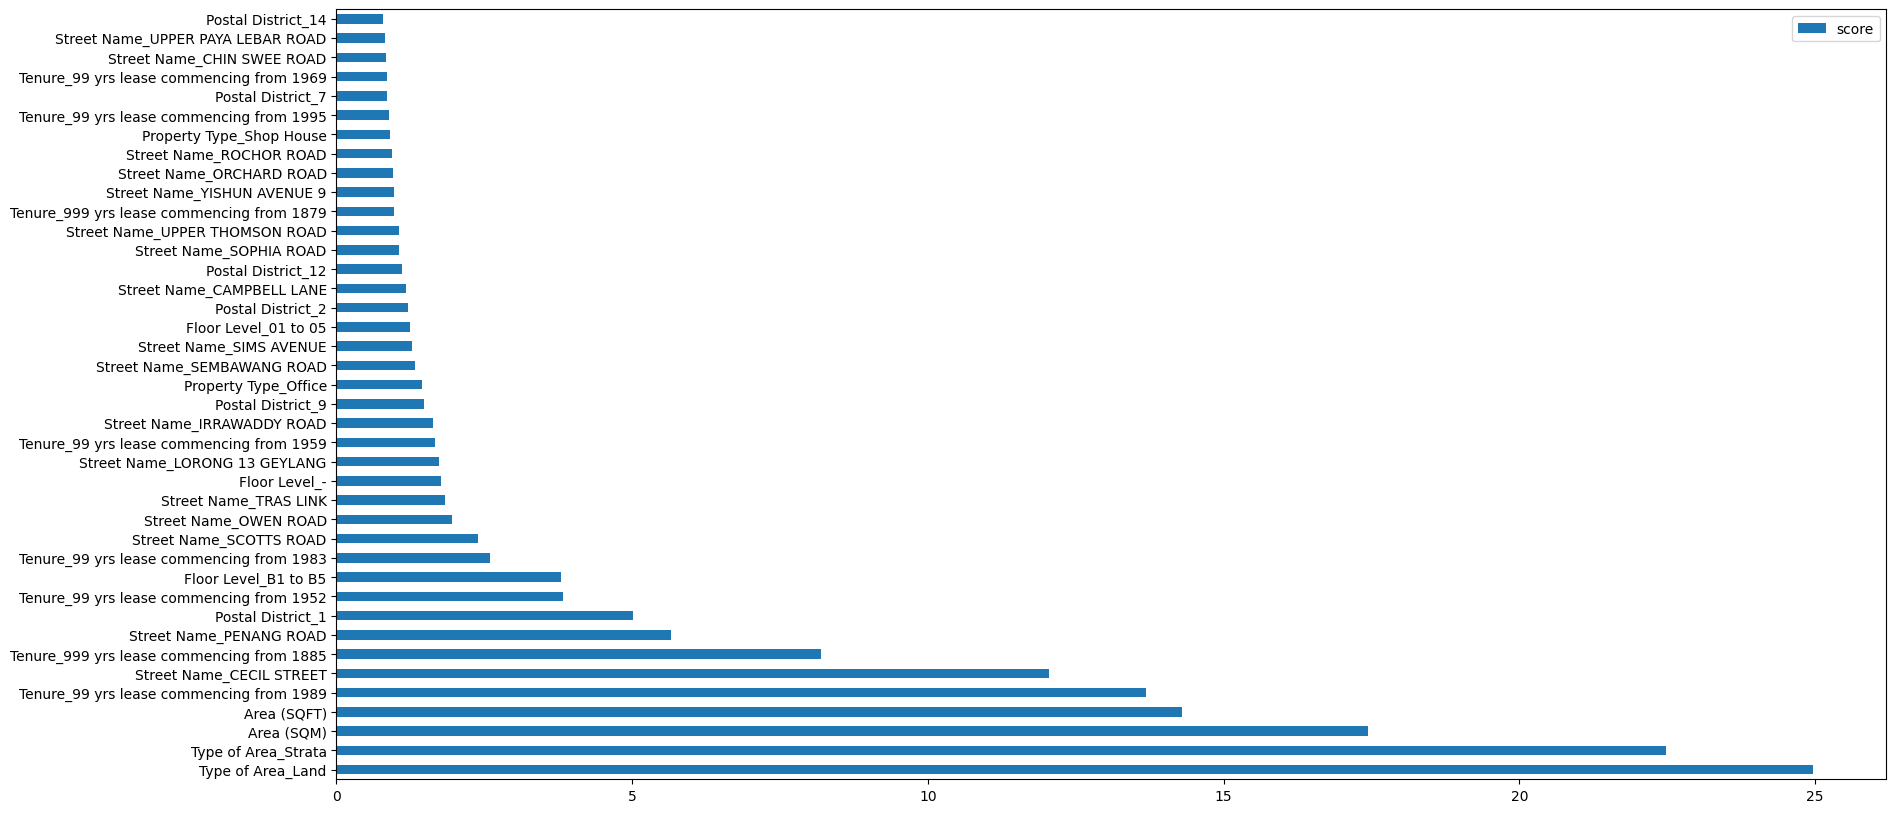

In [ ]:
feature_important = model.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features